# Project: Advance Lane Finding
In this project, your goal is to write a software pipeline to identify the lane boundaries in video from a front-facing camera on a car. The camera calibration images, test road images, and videos are available in this repository. Your job is to take what you've learned in this lesson and write a great lane-finding pipeline! You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images).
There is no starter code provided, but you are welcome to use code from the lesson and quizzes as you like. You may complete the project in a jupyter notebook, but it's not required. Feel free to build it as a standalone project.
For this project, you need to complete the following steps:
First, compute the camera calibration matrix and distortion coefficients given a set of chessboard images (in the camera_cal folder in the repository).
Next, for a series of test images (in the test_images folder in the repository):
- Apply the distortion correction to the raw image.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find lane boundary.
- Determine curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Once you have implemented a successful pipeline on the test images, you will run your algorithm on a video. In the case of the video, you must search for the lane lines in the first few frames, and, once you have a high-confidence detection, use that information to track the position and curvature of the lines from frame to frame.

## Camera Calibration with OpenCV
Extracting object points and image points from the set of chessboard images for camera calibration, and apply distortion correction to them

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
%matplotlib inline

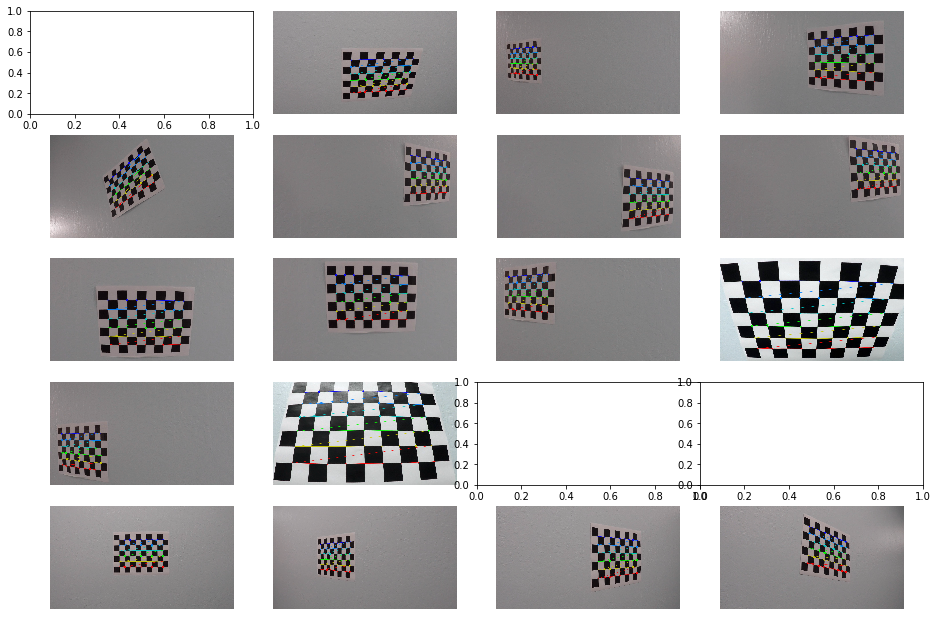

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal\\calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # this step to refine image points was taken from:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)

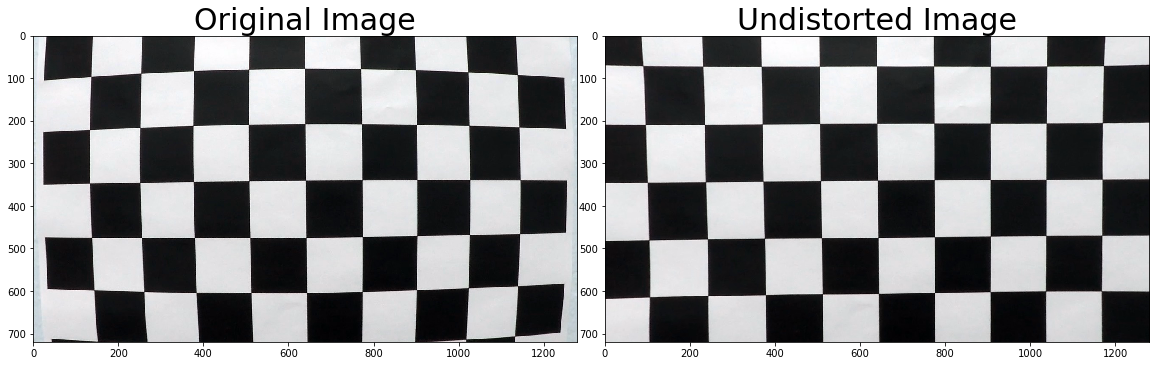

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal\\calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


## An example image

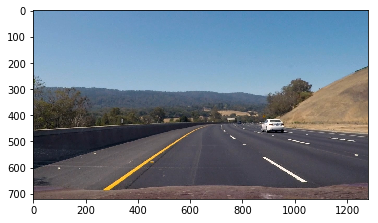

In [4]:
exampleImg = cv2.imread('test_images\\test3.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
plt.imshow(exampleImg)

## Undistort the example image

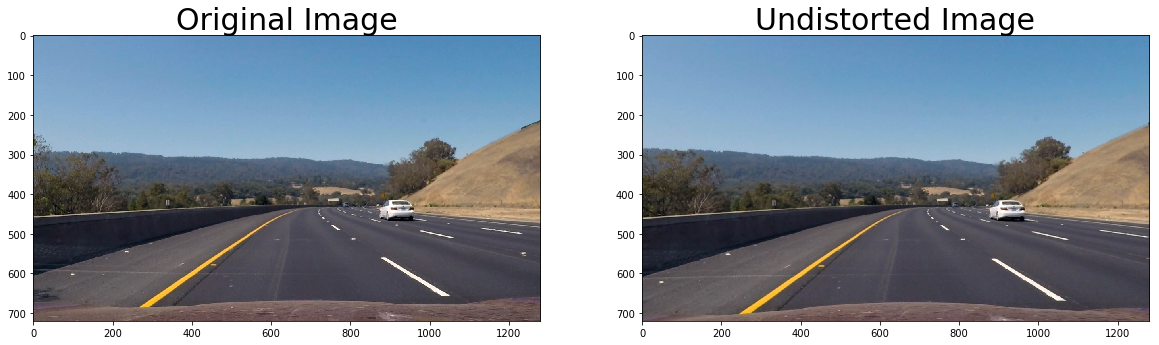

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize =(20,10))

ax1.imshow(exampleImg)
ax1.set_title("Original Image", fontsize=30)
exampleImg_undistort = cv2.undistort(exampleImg, mtx, dist, None, mtx)

ax2.imshow(exampleImg_undistort)
ax2.set_title("Undistorted Image", fontsize=30)

## Perspective transform

In [6]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # M is the transform matrix for unwarping the image
    M = cv2.getPerspectiveTransform(src, dst)
    # inverse_M is the inverse unwarping Matrix
    inverse_M = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, inverse_M

#### Unwarp the example image

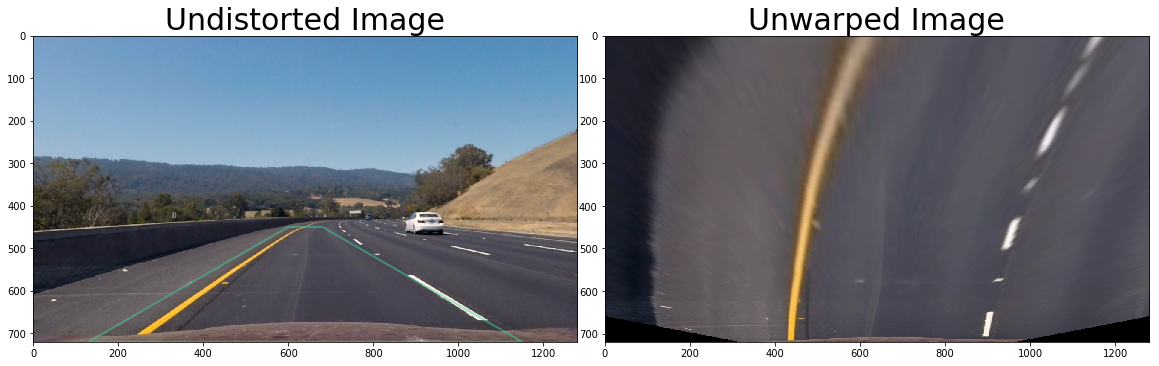

In [7]:
h,w = exampleImg_undistort.shape[:2]

# define source and destination points for transform
src = np.float32([(600,450),
                  (680,450), 
                  (1150,720), 
                  (130,720)])
dst = np.float32([(385,0),
                  (895,0),
                  (895,720),
                  (385,720)])

exampleImg_unwarp, M, Minv = unwarp(exampleImg_undistort, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
ax1.plot(x, y, color='#44cc99', alpha=0.5, linewidth=2, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)

## Sobel Absolute Threshold

In [8]:
def abs_thresh(img, thresh=(0, 255)):
    # Create an image where its pixels are 1 only when the 
    # value of the image input is between the min and max threshold
    binary = np.zeros_like(img)
    binary[(img >= thresh[0]) & (img <= thresh[1])] = 1

    return binary

In [9]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):        
    # SObel derivative either in x or y according to the orient argument
    if  orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise 'orient not recognised'
    
    
    abs_sobel = np.absolute(sobel)
    
    # normalize the sobel derivatives to be between 0 and 255
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    
    # Create an image where its pixels are 1 only when the 
    # value of the image input is between the min and max threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        
    return grad_binary

In [10]:

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # graidents in x and y
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    mag_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # normalize the sobel derivatives to be between 0 and 255
    scaled_sobel = np.uint8(255 * mag_sobelxy/np.max(mag_sobelxy))
    
    # Create an image where its pixels are 1 only when the 
    # value of the image input is between the min and max threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    
    return mag_binary

In [11]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # graidents in x and y
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient_dir = np.arctan2(abs_sobely, abs_sobelx)
        
    # Create an image where its pixels are 1 only when the 
    # value of the image input is between the min and max threshold
    dir_binary = np.zeros_like(gradient_dir)
    dir_binary[(gradient_dir >= thresh[0]) & (gradient_dir <= thresh[1])] = 1
    
       
    return dir_binary

## Detecting Lane

In [12]:
def detect_edges(image, diagnostic=False):
    # Sobel kernel size
    kernel_size = 5 # only odd numbers. If larger then will be smoother gradient measurements

    # Apply each of the thresholding functions
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sobelx_absolute = np.absolute(sobelx)
    sobely_absolute = np.absolute(sobely)

    # Threshold x gradient
    sobelx_absolute_scaled = (255 * sobelx_absolute / np.max(sobelx_absolute))
    sobelx_binary = np.zeros_like(sobelx_absolute_scaled)
    sobelx_binary[(sobelx_absolute_scaled >= 15) & (sobelx_absolute_scaled <= 175)] = 1
        
    # Threshold gradient angle
    sobel_angle = np.arctan2(sobely_absolute, sobelx_absolute)
    sobel_angle_binary = np.zeros_like(sobel_angle).astype(np.uint8)
    sobel_angle_binary[(sobel_angle >= 0.1 * np.pi/2) & (sobel_angle <=  0.5 * np.pi/2)] = 1
        
    # Extract the H, L and S channels
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
        
    # Histogram equalization to attenuate lighting differences
    h_eq = cv2.equalizeHist(h)
    l_eq = cv2.equalizeHist(l)
    s_eq = cv2.equalizeHist(s)

    # Threshold color channels
    h_binary = np.zeros_like(h_eq)
    h_binary[(h_eq >= 0) & (h_eq <= 160)] = 1
    l_binary = np.zeros_like(l_eq)
    l_binary[(l_eq >= 250) & (l_eq <= 255)] = 1
    s_binary = np.zeros_like(s_eq)
    s_binary[(s_eq >= 250) & (s_eq <= 255)] = 1
        
    # Combine the binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[((l_binary == 1) | (s_binary == 1) | (sobelx_binary == 1)) & (sobel_angle_binary == 1)] = 1
        
    image_to_fit = combined_binary
    
    
    if diagnostic:
        # Plot the result
        f, ((a1, a2), (b1, b2), (c1, c2)) = plt.subplots(3, 2, figsize=(24, 32))
        f.tight_layout()

        a1.imshow(sobelx_binary, cmap='gray')
        a1.set_title('sobelx_binary', fontsize=50)
        a2.imshow(sobel_angle_binary, cmap='gray')
        a2.set_title('sobel_angle_binary', fontsize=50)

        b1.imshow(h_binary, cmap='gray')
        b1.set_title('h_binary', fontsize=50)
        b2.imshow(l_binary, cmap='gray')
        b2.set_title('l_binary', fontsize=50)

        c1.imshow(s_binary, cmap='gray')
        c1.set_title('s_binary', fontsize=50)
        c2.imshow(image_to_fit, cmap='gray')
        c2.set_title('Output', fontsize=50)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    return image_to_fit

## Sliding Window and Polynomial Fit

In [13]:
def fit_polynomials(binary_warped, diagnostic=False):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if diagnostic:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        cv2.imwrite('output_images/test.jpg', cv2.cvtColor(np.float32(out_img), cv2.COLOR_RGB2BGR))
        plt.figure(figsize=(20,10))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return ploty, left_fitx, right_fitx, left_fit, right_fit

In [14]:
def fast_fit_polynomials(binary_warped, left_fit,  right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit

## Curvature Estimation

In [15]:
def get_curvature(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 500 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')

    return (left_curverad+right_curverad)/2

In [16]:
def get_perspective_rectangles(image):
    size_top=70
    size_bottom=370
    height, width = image.shape[0:2]
    output_size = height/2

    src = np.float32([[(width/2) - size_top, height*0.65], [(width/2) + size_top, height*0.65], [(width/2) + size_bottom, height-50], [(width/2) - size_bottom, height-50]])
    dst = np.float32([[(width/2) - output_size, (height/2) - output_size], [(width/2) + output_size, (height/2) - output_size], [(width/2) + output_size, (height/2) + output_size], [(width/2) - output_size, (height/2) + output_size]])

    return src, dst

In [17]:
def render_lane(image, ploty, left_fitx, right_fitx):

    # src, dst = get_perspective_rectangles(image)
    # Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Create another one for the distance arrow between the lanes
    warp_zero2 = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp2 = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Draw an arrow between the 2 detected lanes and text of the distance between them (@ y=500)
    y_ref = 350
    left_lane_pos = np.int(left_fitx[y_ref])
    right_lane_pos = np.int(right_fitx[y_ref])
    color = [255, 255, 255]
    thickness_arrow = 10
    
    cv2.arrowedLine(color_warp2, (left_lane_pos, y_ref), (right_lane_pos, y_ref), color, thickness = thickness_arrow)
    cv2.arrowedLine(color_warp2, (right_lane_pos, y_ref), (left_lane_pos, y_ref), color, thickness = thickness_arrow)
    
    font_scale = 3
    thickness = 10
    lane_width_at_middle = np.abs(right_lane_pos - left_lane_pos) * 3.7/500 # Meters per pixel in x dimension
    middle_text = "{0:5.2f}m".format(lane_width_at_middle)
    text_size, base_line = cv2.getTextSize(middle_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    
    x_middle = np.int((left_lane_pos + right_lane_pos) / 2 - text_size[0] / 2)
    middle_pos = (x_middle, y_ref + text_size[1] + base_line)
    
    cv2.putText(color_warp2, middle_text, middle_pos, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newwarp2 = cv2.warpPerspective(color_warp2, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(result, 1, newwarp2, 1, 0)
    
    return result

In [18]:
global_left_fit = None
global_right_fit = None

def process_image(input_image):
    
    
    global global_left_fit
    global global_right_fit
    
    # step 1: undistort image
    image_undistort = cv2.undistort(input_image, mtx, dist, None, mtx)
    
    # step 2: perspective transform
    image_transformed, M, inverse_M = unwarp(image_undistort, src, dst)
    
    # step 3: detect binary lane markings
    image_binary = detect_edges(image_transformed)
    
    # step 4: fit polynomials
    if global_left_fit is not None:
        ploty, left_fitx, right_fitx, left_fit, right_fit = fast_fit_polynomials(image_binary, global_left_fit, global_right_fit)
    else:
        ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomials(image_binary)
    
    global_left_fit = left_fit
    global_right_fit = right_fit
    
    # step 5: draw lane
    output_lane = render_lane(image_undistort, ploty, left_fitx, right_fitx)
    
    # step 6: print curvature
    curv = get_curvature(ploty, left_fitx, right_fitx)
    output_curvature = cv2.putText(output_lane, "Radius of Curvature of the lane: " + str(int(curv)) + "m", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 
                                   1, [255, 255, 255], 2)

    # step 7: print road position
    xm_per_pix = 3.7/500
    # left_lane_pos = left_fitx[len(left_fitx)-1]
    # right_lane_pos = right_fitx[len(right_fitx)-1]
    left_lane_pos = left_fitx[-1]
    right_lane_pos = right_fitx[-1]
    road_pos = (((left_lane_pos + right_lane_pos) / 2) - 640) * xm_per_pix
    output_road_pos = cv2.putText(output_lane, "Vehicle Offset from lane center: {0:.2f}m".format(road_pos), (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 
                                  1, [255, 255, 255],  2)

    # output from processing step
    output_image = output_road_pos
    
    # Add diagnostic images on the upper right corner
    x_offset = image_transformed.shape[1]-np.floor(image_transformed.shape[1]/5)
    y_offset = 0
    
    # Resize the diagnostic images to small thumbnails (1/5th its original size)
    image_transformed_thumbnail = cv2.resize(src = image_transformed, 
                                             dsize = (0,0), fx = 0.2, fy = 0.2, interpolation = cv2.INTER_CUBIC)
    image_binary_thumbnail = cv2.resize(src = image_binary, 
                                             dsize = (0,0), fx = 0.2, fy = 0.2, interpolation = cv2.INTER_CUBIC) * 255
    
    output_image[y_offset:y_offset+np.int(image_transformed.shape[0]/5), 
                 x_offset:x_offset+np.int(image_transformed.shape[1]/5)] = image_transformed_thumbnail
    
    x_offset = image_transformed.shape[1]-np.floor(image_transformed.shape[1]/5)
    y_offset = np.floor(image_transformed.shape[0]/5)
    
    output_image[y_offset:y_offset+np.int(image_transformed.shape[0]/5), 
                 x_offset:x_offset+np.int(image_transformed.shape[1]/5)] = np.dstack((image_binary_thumbnail, 
                                                                            image_binary_thumbnail, 
                                                                            image_binary_thumbnail))
    
    

    
    # function should always output color images
    if len(output_image.shape) == 2:
        return cv2.cvtColor(np.float32(output_image), cv2.COLOR_GRAY2RGB)
    else:
        return output_image

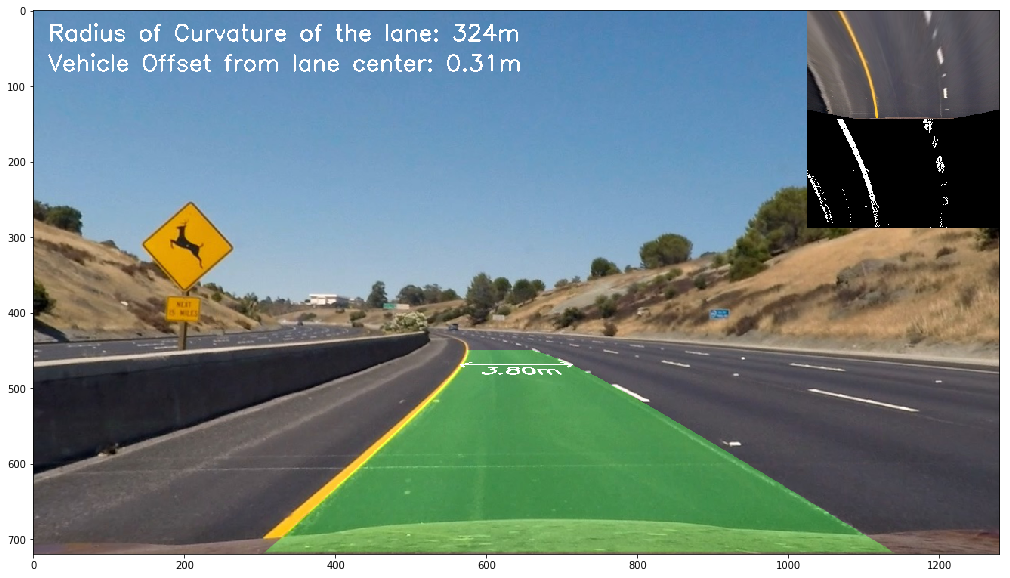

In [19]:

test_image_file_name = 'test_images\\test2.jpg'

test_image = mpimg.imread(test_image_file_name)
test_output = process_image(test_image)



fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(test_output)

plt.show()


In [20]:
project_output_file = "project_output_12.mp4"
project_video = VideoFileClip("project_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video project_output_12.mp4
[MoviePy] Writing video project_output_12.mp4


100%|██████████████████████████████████████████████████▉| 1260/1261 [03:26<00:00,  6.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_12.mp4 

Wall time: 3min 27s


In [21]:
project_output_file = "challenge_output_12.mp4"
project_video = VideoFileClip("challenge_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video challenge_output_12.mp4
[MoviePy] Writing video challenge_output_12.mp4


100%|█████████████████████████████████████████████████████| 485/485 [01:19<00:00,  5.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output_12.mp4 

Wall time: 1min 20s


In [22]:
project_output_file = "harder_challenge_output_12.mp4"
project_video = VideoFileClip("harder_challenge_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video harder_challenge_output_12.mp4
[MoviePy] Writing video harder_challenge_output_12.mp4


100%|██████████████████████████████████████████████████▉| 1199/1200 [03:20<00:00,  5.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output_12.mp4 

Wall time: 3min 21s
